In [1]:
import pandas as pd

In [2]:
def ingest_train():
    data = pd.read_csv("dataset/dataset.csv", encoding='latin-1')
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    return data

In [3]:
train = ingest_train()

In [4]:
train.describe()

,Sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [5]:
train.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


# Data Preparation
Now, It looks like it’s time for some cleaning!

Let's first define data cleaning function, an then apply it to the whole dataset. This function remove URL, remove HTML tags, handle negation words which are splited into two parts, convert the words to lower cases, remove all non-letter characters. These elements are very common and they do not provide enough semantic information for the task.

In [6]:
import re

pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

In [7]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

In [8]:
def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'

 The results of this should give us a cleaned datasets and remove lines with 'NC'.

Next, let's define a handy function to monitor DataFrame creations, then look at our cleaned data.

In [9]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=1000000):
    data = data.head(n)
    data['SentimentText'] = data['SentimentText'].progress_map(data_cleaner)  
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

In [10]:
train = post_process(train)

progress-bar: 100%|████████████████████| 25000/25000 [00:07<00:00, 3281.07it/s]


# Data visualization
Before proceeding to the classification step, let's do some visualization of our textual data. the words cloud is a best choice for this matter, it is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color. This format is useful for quickly perceiving the most prominent terms.

For this data viz, we use the python library wordcloud.

Let's beging with the word cloud of negative terms.

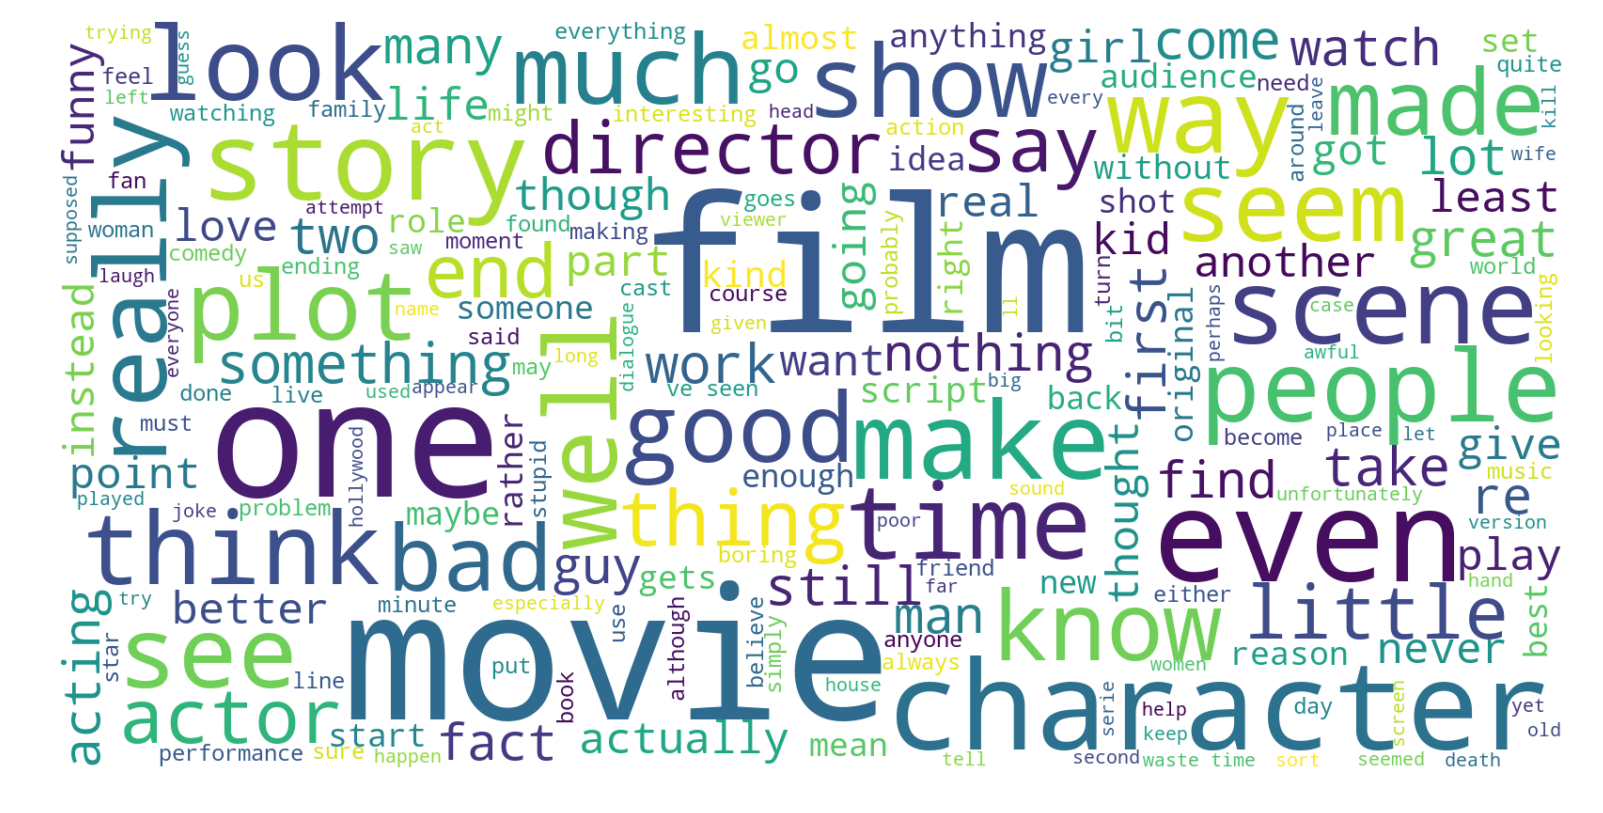

In [11]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_tweets = train[train.Sentiment == 0]
neg_string = []
for t in neg_tweets.SentimentText:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The world cloud for the positive terms.

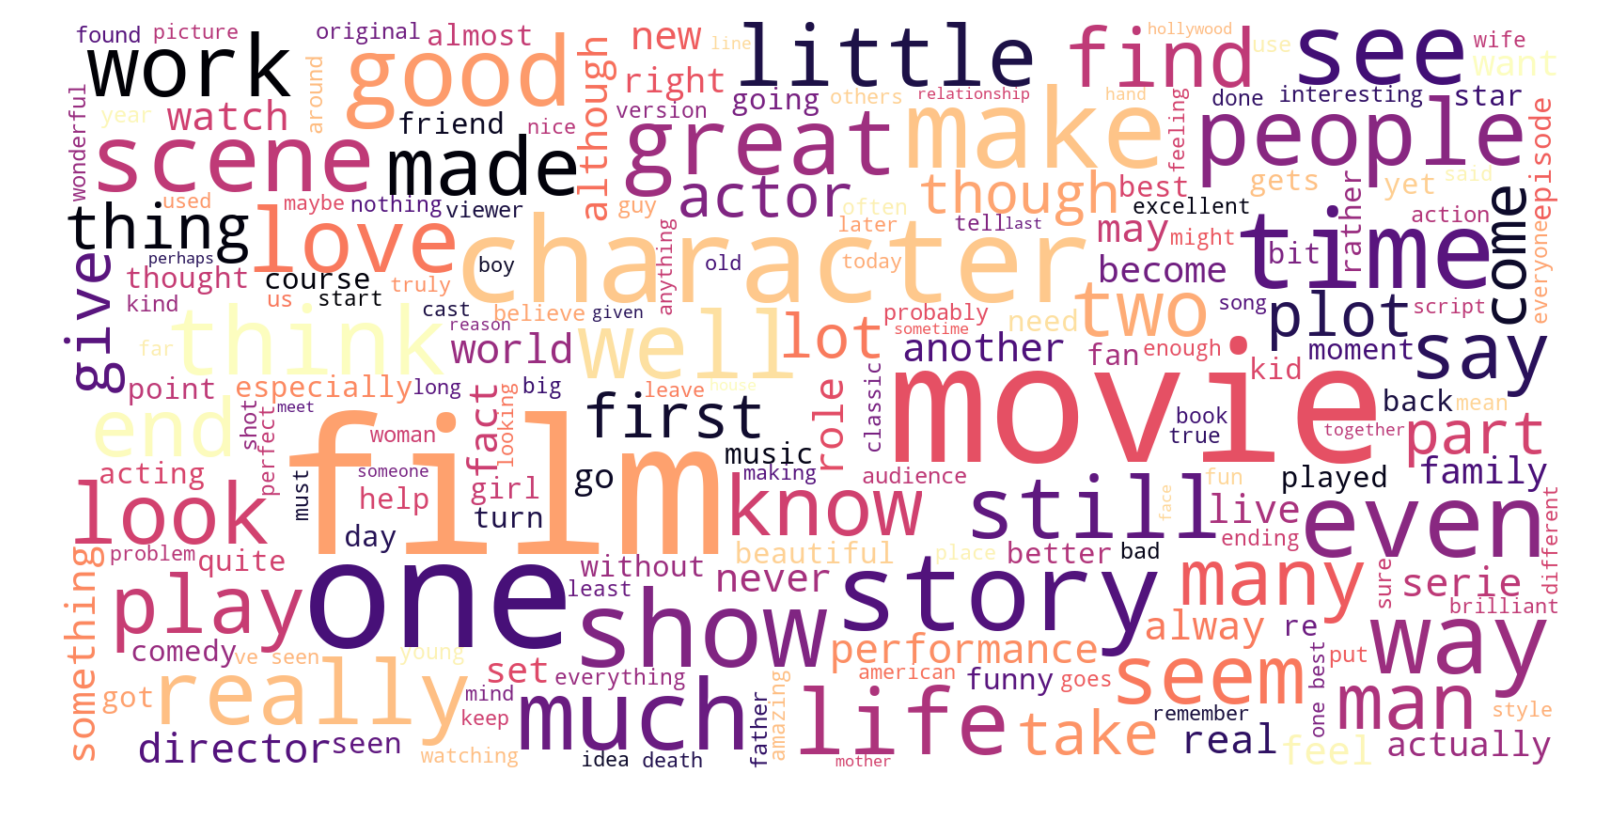

In [12]:
pos_tweets = train[train.Sentiment == 1]
pos_string = []
for t in pos_tweets.SentimentText:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

# Building the models
Before proceeding to the training phase, let's split our data into training and validation set.



In [13]:
from sklearn.cross_validation import train_test_split
SEED = 2000

x_train, x_validation, y_train, y_validation = train_test_split(train.SentimentText, train.Sentiment, test_size=.2, random_state=SEED)


C:\Users\it\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Features Extraction
In this part, we will use a feature extraction technique called Tfidf vectorizer of 100,000 features including up to trigram. This technique is a way to convert textual data to numeric form.

In the below function, we will use a custom function that reports validation accuracy, the average precision_recall, and the time it took to train and evaluate.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time

def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)
vec = TfidfVectorizer()
def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result
result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Average precision-recall score: 0.85
accuracy score: 89.36%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Average precision-recall score: 0.86
accuracy score: 90.48%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, 

C:\Users\it\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Average precision-recall score: 0.84
accuracy score: 89.02%
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


C:\Users\it\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Average precision-recall score: 0.86
accuracy score: 90.12%
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
Average precision-recall score: 0.75
accuracy score: 81.50%
--------------------------------------------------------------------------------


# Now we plot the summary of this comparison like below, namely the accuracy of each model, their train and test time, and their average precision.

In [16]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np

acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
     y=avg_,
    name='Average precision (%)'
)


data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')


# We can show furthermore the performance of our classifiers by using the ROC Curve technique. This curve plots two parameters: True Positive Rate, False Positive Rate

In [17]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
    


In [18]:
py.iplot(fig)

# Thus, It looks like Ridge Classifier and Linear SVC are the best performing classifier in our case.

What if we train an ensemble classifier of the top four accurate models, and see if there is any improvement ;) In that case I will use a voting ckassifier, and plot its ROC beside the four models.

In [19]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

_fp_ = []
_tp_ = []
names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], names):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    _fp_.append(fp)
    _tp_.append(tp)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Average precision-recall score: 0.85
accuracy score: 89.36%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Average precision-recall score: 0.86
accuracy score: 90.48%
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Average precision-recall score: 0.83
accuracy score: 87.86%
-------

C:\Users\it\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



Average precision-recall score: 0.86
accuracy score: 90.04%
--------------------------------------------------------------------------------
Validation result for Ensemble
VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svc', Linear...   n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)


C:\Users\it\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\it\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Average precision-recall score: 0.87
accuracy score: 90.76%
--------------------------------------------------------------------------------


In [20]:
data = []
for i in range(0, len(_fp_)):
    trace = go.Scatter(x=_fp_[i], y=_tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
    
py.iplot(fig)